# SINDy

For users already familiar with the interface, see the [API docs](../api/index_sindy.rst).

SINDy stands for Sparse Identification of Nonlinear Dynamics <cite data-cite="sindy-brunton2016sindy">(Brunton, 2016)</cite>. It is a data-driven method for discovering dynamical systems models from measurement data using sparse regression.

## Main ideas
Suppose we have a set of measurements $x(t)\in \mathbb{R}^n$ from some physical system at different points in time $t$. SINDy attempts to represent the time evolution of $x(t)$ in terms of a nonlinear function $f$:

$$ \frac{d}{dt}x(t) = f(x(t)). $$

This equation constitutes a *dynamical system* for the measurements $x(t)$. The vector $x(t)=[x_1(t), x_2(t), \dots x_n(t)]^\top$ gives the state of the physical system at time $t$. The function $f(x(t))$ constrains how the system evolves in time.

The key idea behind SINDy is that the function $f$ is often **sparse** in the space of an appropriate set of basis functions. For example, the function

$$ 
	\frac{d}{dt}x = f(x)
	= \begin{bmatrix} f_1(x)\\f_2(x) \end{bmatrix}
	= \begin{bmatrix}-2 + x_1^2 + 3x_1x_2 \\ 7x_2^4 - 2x_1^3 \end{bmatrix}
$$

is sparse with respect to the set of polynomials of two variables in the sense that if we were to write an expansion of the component functions of $f$ in this basis (e.g. $f_{1}(x) = \sum_{i=0}^\infty\sum_{j=0}^\infty a_{i,j}x_1^ix_2^j$), only a small number of coefficients ($a_{i,j}$) would be nonzero.

SINDy employs **sparse regression** to find a linear combination of basis functions that best capture the dynamic behavior of the physical system.

## Approximation problem
To apply SINDy in practice one needs a set of measurement data collected at times $t_1, t_2, \dots, t_n$, and the time derivatives of these measurements (either measured directly or numerically approximated). These data are aggregated into the matrices $X$ and $\dot X$, respectively

$$
	X = \begin{bmatrix}
		x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
		x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
		\vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
	\end{bmatrix},
	\qquad
	\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
		\dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
		\vdots & \vdots & & \vdots \\
		\dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
	\end{bmatrix}.
$$

Next, one forms a library matrix $\Theta(X)$ whose columns consist of a chosen set of basis functions applied to the data

$$
	\Theta(X) = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
		\mid & \mid & & \mid 
	\end{bmatrix}.
$$

For example, if $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ are monomials ($\theta_i(x) = x^{i-1}$), then 

$$
	\theta_3(X) = \begin{bmatrix}
		\mid & \mid & & \mid & \mid & & \mid \\
		x_1(t)^2 & x_1(t)x_2(t) & \dots & x_2(t)^2 & x_2(t)x_3(t) & \dots & x_n^2(t) \\
		\mid & \mid & & \mid & \mid & & \mid
	\end{bmatrix},
$$

where vector products and powers are understood to be element-wise.

We seek a set of sparse coefficient vectors (collected into a matrix)

$$
	\Xi = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\xi_1 & \xi_2 & \dots & \xi_n \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

The vector $\xi_i$ provides the coefficients for a linear combination of basis functions $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ representing the $i$th component function of $f$: $f_i(x)$. That is to say, $f_i(x) = \Theta\left(x^\top\right) \xi_i$, where $\Theta\left(x^\top\right)$ is understood to be a row vector consisting of symbolic functions (whereas $\Theta(X)$ is a matrix whose entries are numerical values).

With each of the objects $X$, $\dot X$, $\Theta(X)$, and $\Xi$ being defined, we are ready to write down the approximation problem underlying SINDy:

$$ \dot X \approx \Theta(X)\Xi. $$

## Deeptime SINDy objects
Deeptime has two SINDy objects:

* [SINDy](https://deeptime-ml.github.io/api/generated/deeptime.sindy.SINDy.html#deeptime.sindy.SINDy) is used to solve the above optimization problem given $\Theta$, $X$, and (optionally) $\dot{X}$. By default $\Theta$ is a polynomial library of degree 2 and the sequentially-thresholded least-squares algorithm <cite data-cite="sindy-brunton2016sindy">(Brunton, 2016)</cite> is used to solve the optimization problem. If $\dot{X}$ is not passed in, then it is estimated from $X$ with a first order finite difference method.
* [SINDyModel](https://deeptime-ml.github.io/api/generated/deeptime.sindy.SINDyModel.html#deeptime.sindy.SINDyModel) represents the learned dynamical system. It can be used to predict derivatives given state variables, simulate forward in time from novel initial conditions, and to score itself against ground truth data.

Let's see how these objects work with an example.

## Example
Suppose we have measurements of the position of a particle obeying the following dynamical system at different points in time:

$$
	\frac{d}{dt} \begin{bmatrix} x \\ y \end{bmatrix}
	= \begin{bmatrix} -2x \\ y \end{bmatrix}
	= \begin{bmatrix} -2 & 0 \\ 0 & 1 \end{bmatrix}
	\begin{bmatrix} x \\ y \end{bmatrix}
$$

Note that this system of differential equations decouples into two differential equations whose solutions are simply $x(t) = x_0e^{-2t}$ and $y(t) = y_0e^t$, where $x_0 = x(0)$ and $y_0=y(0)$ are the initial conditions.

Using the initial conditions $x_0 = 3$ and $y_0 = \tfrac{1}{2}$, we construct the data matrix $X$.

In [1]:
import numpy as np
import deeptime as dt

In [2]:
t = np.linspace(0, 1, 100)
x = 3 * np.exp(-2 * t)
y = 0.5 * np.exp(t)
X = np.stack((x, y), axis=-1)  # First column is x, second is y

To form a [SINDy](https://deeptime-ml.github.io/api/generated/deeptime.sindy.SINDy.html#deeptime.sindy.SINDy) estimator we can select a feature library and an optimization routine.

Let's use polynomials of degree up to three for the candidate library $\Theta$ and sequentially-thresholded least-squares with a threshold of 0.2 to solve the optimization problem

In [3]:
from sklearn.preprocessing import PolynomialFeatures

library = PolynomialFeatures(degree=3)

optimizer = dt.sindy.STLSQ(threshold=0.2)

Following the `scikit-learn` workflow, we first instantiate a `SINDy` estimator with the desired properties, then fit it to the data in separate step.

In [4]:
# Instantiate the estimator
estimator = dt.sindy.SINDy(
    library=library,
    optimizer=optimizer,
    input_features=["x", "y"]  # The feature names are just for printing
)

# Fit the estimator to data
estimator.fit(X, t=t);

Once the estimator has been fit, we extract the learned model.

In [5]:
model = estimator.fetch_model();

We can inspect the governing equations discovered by SINDy and check whether they seem reasonable with the `print` function.

In [6]:
model.print()

x' = -1.999 x
y' = 0.999 y


The learned model is very close to the true governing equations!

We can use it to evolve new initial conditions forward in time with the [simulate](https://deeptime-ml.github.io/api/generated/deeptime.sindy.SINDyModel.html#deeptime.sindy.SINDyModel.simulate) method.

In [7]:
x0 = 6
y0 = -0.1

t_test = np.linspace(0, 1, 100)
x_test = x0 * np.exp(-2 * t_test)
y_test = y0 * np.exp(t_test)

sim = model.simulate([x0, y0], t=t_test)

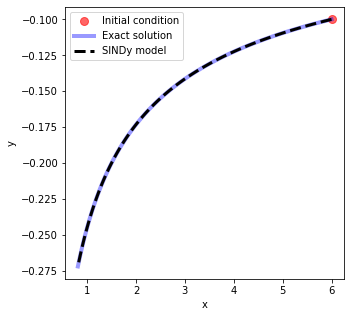

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
ax.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=4)
ax.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
ax.set(xlabel="x", ylabel="y")
ax.legend();

For more fine-grained control over various aspects of SINDy (e.g. different optimizers or feature libraries), the [PySINDy](http://pysindy.readthedocs.org/) package provides Deeptime API-compatible [objects](https://pysindy.readthedocs.io/en/latest/api/pysindy.deeptime.html).